In [5]:
import os
os.chdir("/home/acmlab/PycharmProjects1/pythonProject1/2025IECON")
print(os.getcwd())

/home/acmlab/PycharmProjects1/pythonProject1/2025IECON


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torch.nn import functional as F
from datetime import datetime
import random

X_1 = pd.read_csv('Train_x_1.csv')
Y_1 = pd.read_csv('Train_y_1.csv')
X_2 = pd.read_csv('Train_x_2.csv')
Y_2 = pd.read_csv('Train_y_2.csv')
X_3 = pd.read_csv('Train_x_3.csv')
Y_3 = pd.read_csv('Train_y_3.csv')
X_4 = pd.read_csv('Train_x_4.csv')
Y_4 = pd.read_csv('Train_y_4.csv')
X_5 = pd.read_csv('Train_x_5.csv')
Y_5 = pd.read_csv('Train_y_5.csv')
X_6 = pd.read_csv('Train_x_6.csv')
Y_6 = pd.read_csv('Train_y_6.csv')
X_7 = pd.read_csv('Train_x_7.csv')
Y_7 = pd.read_csv('Train_y_7.csv')
X_8 = pd.read_csv('Train_x_8.csv')
Y_8 = pd.read_csv('Train_y_8.csv')
X_9 = pd.read_csv('Train_x_9.csv')
Y_9 = pd.read_csv('Train_y_9.csv')
X_10 = pd.read_csv('Train_x_10.csv')
Y_10 = pd.read_csv('Train_y_10.csv')

X_list = [X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10]
Y_list = [Y_1, Y_2, Y_3, Y_4, Y_5, Y_6, Y_7, Y_8, Y_9, Y_10]

class SimpleNN(nn.Module):
    def __init__(self, input_dim=21):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 7)
        self.relu = nn.ReLU()

    def forward(self, x, params=None):
        x = x.reshape(x.shape[0], -1)
        if params is None:
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            x = self.fc3(x)
        else:
            x = torch.tanh(F.linear(x, params['fc1.weight'], params['fc1.bias']))
            x = torch.tanh(F.linear(x, params['fc2.weight'], params['fc2.bias']))
            x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
        return x

class HNetwork(nn.Module):
    def __init__(self, input_dim=7):
        super(HNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x, params=None):
        x = x.reshape(x.shape[0], -1)
        if params is None:
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            x = self.fc3(x)
        else:
            x = torch.tanh(F.linear(x, params['fc1.weight'], params['fc1.bias']))
            x = torch.tanh(F.linear(x, params['fc2.weight'], params['fc2.bias']))
            x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
        return x

model = SimpleNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

h = HNetwork()
opt_max = optim.Adam(h.parameters(), lr=1e-3)


a_list = [torch.randn(7, 7) for _ in range(10)]
b_list = [np.zeros(7) for _ in range(10)]
a_star = [np.zeros(7) for _ in range(10)]

def train_maml(num_epochs, inner_lr=0.002):
    a_history = []
    loss_history = []
    for epoch in range(num_epochs):
        meta_loss = 0
        h_loss = 0
        a = np.zeros(7)
        x_dataset = []
        y_dataset = []
        x_train_list = []
        y_train_list = []
        x_adapt_list = np.zeros((1,21))
        y_adapt_list = np.zeros((1,7))
        num_samples = 4
        for i in random.sample(range(10), num_samples):
            x_train, x_adapt, y_train, y_adapt = train_test_split(X_list[i], Y_list[i], test_size=0.2)
            x_adapt_tensor = torch.tensor(np.array(x_adapt), dtype=torch.float32)
            y_adapt_tensor = torch.tensor(np.array(y_adapt), dtype=torch.float32)
            Phi_tensor = model(x_adapt_tensor)
            Phi = Phi_tensor.detach().numpy()
            Y = y_adapt_tensor.detach().numpy()
            for j in range(7):
                numerator = np.sum(Phi[:,j] * Y[:,j])
                denominator = np.sum(Phi[:,j]**2)
                a[j] = numerator / denominator
            # if np.linalg.norm(a) > 2:
            #     a = 2 * a / np.linalg.norm(a)
            # a_star[i] = a
            a_star[i] = a_star[i] + 0.1 * (a - a_star[i])

            x_train_tensor = torch.tensor(np.array(x_train), dtype=torch.float32)
            y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32)

            phi_output = model(x_train_tensor)
            pred_y2 = phi_output * torch.tensor(np.array(a_star[i]), dtype=torch.float32)
            loss = loss_fn(pred_y2, y_train_tensor)


            with torch.no_grad():
                phi_detached = phi_output.detach()

            logits = h(phi_detached)
            class_idx = torch.full((x_train_tensor.shape[0],), i, dtype=torch.long)
            loss_cls = F.cross_entropy(logits, class_idx)

            h_loss = h_loss + loss_cls

            meta_loss = meta_loss + loss - 0.1 * loss_cls

        a_history.append(a_star[3])
        loss_history.append(meta_loss.item())
        # Meta Update
        optimizer.zero_grad()
        meta_loss.backward(retain_graph=True)
        optimizer.step()

        # H update
        opt_max.zero_grad()
        h_loss.backward()
        opt_max.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {meta_loss.item():.4f}')
    plt.figure(1)
    plt.plot(np.array(a_history)[:, 0], label='a1')
    plt.plot(np.array(a_history)[:, 1], label='a2')
    plt.plot(np.array(a_history)[:, 2], label='a3')
    plt.plot(np.array(a_history)[:, 3], label='a4')
    plt.plot(np.array(a_history)[:, 4], label='a5')
    plt.plot(np.array(a_history)[:, 5], label='a6')
    plt.plot(np.array(a_history)[:, 6], label='a7')
    plt.legend()
    plt.show()
    plt.figure(2)
    plt.plot(np.array(loss_history))
    plt.title('Loss')
    plt.show()
    # np.savetxt('Loss_Proposed.csv', np.array(loss_history), delimiter=',', comments='', fmt='%d')

Epoch [100/1000], Loss: 2.1514
Epoch [200/1000], Loss: 1.1243
Epoch [300/1000], Loss: 0.2772
Epoch [400/1000], Loss: 0.0696
Epoch [500/1000], Loss: -0.1759
Epoch [600/1000], Loss: -0.4722
Epoch [700/1000], Loss: -0.4676
Epoch [800/1000], Loss: -0.4926
Epoch [900/1000], Loss: -0.4161
Epoch [1000/1000], Loss: -0.3683


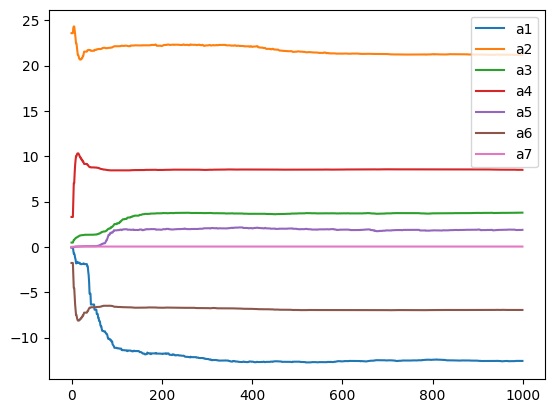

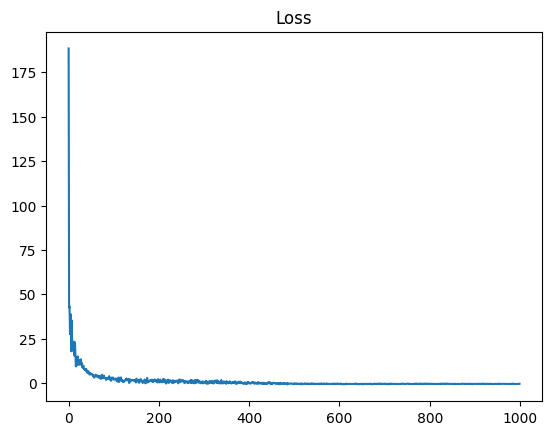

In [7]:
# Train
train_maml(num_epochs=1000)
# torch.save(model.state_dict(), "model_2.pth")

In [8]:
print(a_star)

[array([-9.85815843e+00,  1.68711640e+01,  2.86627102e+00,  3.66077646e+00,
        8.72090724e-01, -5.77391552e-01,  2.51138484e-03]), array([-1.06394821e+01,  1.74656953e+01,  3.11762088e+00,  5.51678247e+00,
        1.21550329e+00, -2.06347620e+00,  1.05464210e-02]), array([-11.32710979,  18.78500946,   3.25695834,   7.06986184,
         1.39210786,  -4.40857203,   0.04989947]), array([-12.57432276,  21.18097811,   3.78297746,   8.50490207,
         1.88637375,  -6.95285726,   0.04213378]), array([-11.98501377,  19.88611848,   3.55085881,   7.77156603,
         1.71672743,  -5.65766924,   0.04766897]), array([-12.96312534,  22.65100877,   3.83568198,   9.25179971,
         1.95662395,  -8.08676755,   0.04138298]), array([-10.80835354,  17.98394952,   3.11131098,   6.35999368,
         1.29738014,  -3.21464448,   0.05512709]), array([-10.08904406,  17.25993604,   2.94823861,   4.33901699,
         1.0044715 ,  -0.98815914,   0.06301193]), array([-10.25131423,  17.50849084,   2.964643

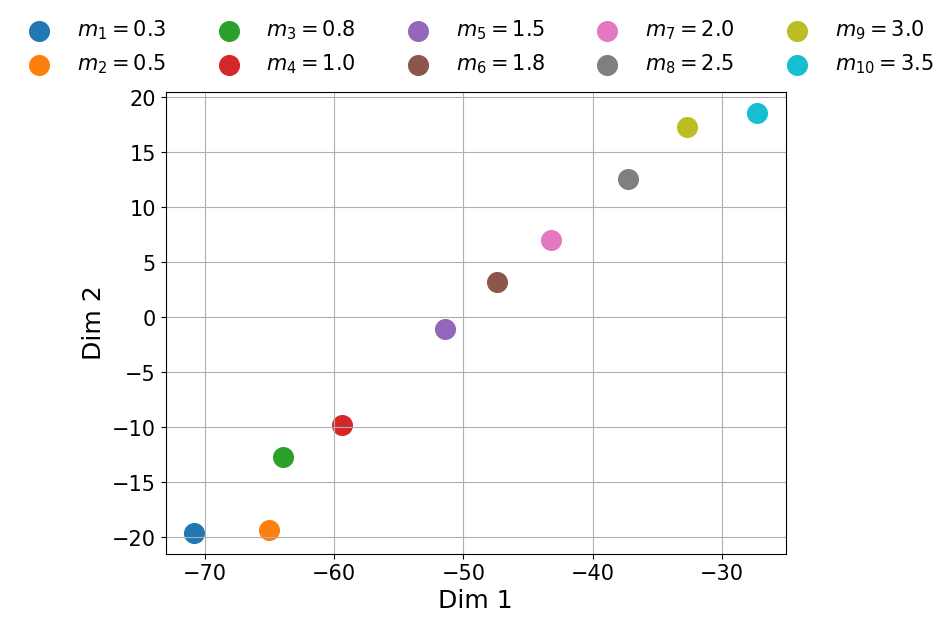

In [15]:
from sklearn.manifold import TSNE
flattened_tensors = [t.view(-1).detach().numpy() for t in torch.tensor(np.array(a_star), dtype=torch.float32)]

tSNE = np.array(flattened_tensors)

tsne = TSNE(n_components=2, perplexity=3)
X_embedded = tsne.fit_transform(tSNE)

plt.figure(figsize=(8, 6))
plt.grid(True)
plt.scatter(X_embedded[0, 0], X_embedded[0, 1], label=r'$m_{1}=0.3$', s=200)
plt.scatter(X_embedded[7, 0], X_embedded[7, 1], label=r'$m_{2}=0.5$', s=200)
plt.scatter(X_embedded[8, 0], X_embedded[8, 1], label=r'$m_{3}=0.8$', s=200)
plt.scatter(X_embedded[1, 0], X_embedded[1, 1], label=r'$m_{4}=1.0$', s=200)
plt.scatter(X_embedded[6, 0], X_embedded[6, 1], label=r'$m_{5}=1.5$', s=200)
plt.scatter(X_embedded[9, 0], X_embedded[9, 1], label=r'$m_{6}=1.8$', s=200)
plt.scatter(X_embedded[2, 0], X_embedded[2, 1], label=r'$m_{7}=2.0$', s=200)
plt.scatter(X_embedded[4, 0], X_embedded[4, 1], label=r'$m_{8}=2.5$', s=200)
plt.scatter(X_embedded[3, 0], X_embedded[3, 1], label=r'$m_{9}=3.0$', s=200)
plt.scatter(X_embedded[5, 0], X_embedded[5, 1], label=r'$m_{10}=3.5$', s=200)
plt.xlabel('Dim 1', fontsize='18')
plt.ylabel('Dim 2', fontsize='18')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=5, frameon=False, fontsize='15')
plt.show()


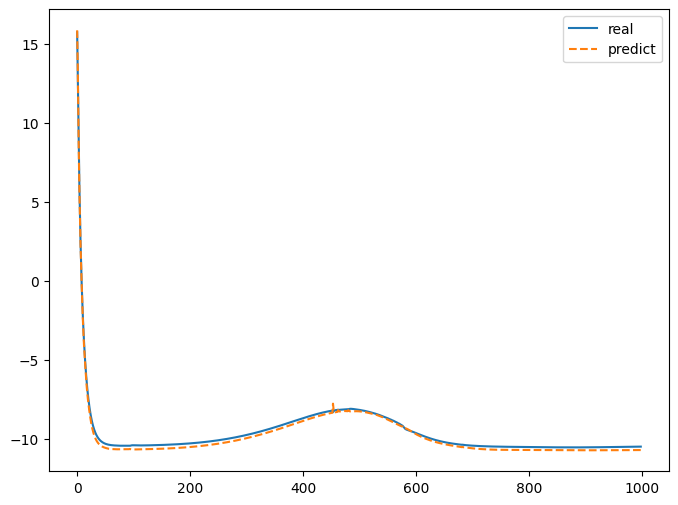

In [15]:
Test_X_1 = pd.read_csv('Test_x_1.csv')
Test_Y_1 = pd.read_csv('Test_y_1.csv')
X_test_update_1 = torch.tensor(np.array(Test_X_1), dtype=torch.float32)
Y_test_update_1 = torch.tensor(np.array(Test_Y_1), dtype=torch.float32)
model1 = SimpleNN()
model1.load_state_dict(torch.load("model_2.pth", weights_only=True))

y_pred = model1(X_test_update_1)
y_pred_original = y_pred * torch.tensor(np.array(a_star[3]), dtype=torch.float32)
# y_pred_original = y_pred @ a_list[4]
y_test_original = Test_Y_1

# mse = mean_squared_error(y_test_original, y_pred_original)
# rmse = np.sqrt(mse)

plt.figure(figsize=(8, 6))
plt.plot(y_test_original.values[:,3], label='real', linestyle='-')
plt.plot(y_pred_original.detach()[:,3], label='predict', linestyle='--')
plt.legend()
plt.show()